In [1]:
import pandas as pd
import numpy as np
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
# from catboost import CatBoostRegressor
import lightgbm as lgb
from math import sqrt
from sklearn.model_selection import KFold
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

plt.rcParams['figure.figsize'] = [16, 10]

In [2]:
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')
print(df_train.shape, df_test.shape)

(2822, 63) (1013, 62)


In [3]:
ward = df_test[['ward']]
ward.head()

,ward
0,21001001: Ward 1
1,21001002: Ward 2
2,21001003: Ward 3
3,21001004: Ward 4
4,21001005: Ward 5


In [4]:
df_train.iloc[:, :10].head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818


In [5]:
description = pd.read_csv('variable_descriptions.csv')
description[['Column','Description']].head()

,Column,Description
0,dw_00,Percentage of dwellings of type: House or bric...
1,dw_01,Percentage of dwellings of type: Traditional d...
2,dw_02,Percentage of dwellings of type: Flat or apart...
3,dw_03,Percentage of dwellings of type: Cluster house...
4,dw_04,Percentage of dwellings of type: Townhouse (se...


In [0]:
# description.to_csv('description.csv', index=False)

In [7]:
#df_train[df_train.dtypes[df_train.dtypes != 'float64'].index]

In [8]:
len(df_train.ward.unique()), len(df_train.ADM4_PCODE.unique())

(2822, 2822)

 dw_12, dw_13, lan_13, pw_07, pw_08 columns have zero values, and the other two columns(ward, ADM4_PCODE) are identifiers so we drop them from the data

In [9]:
df_train.drop(columns=['dw_12', 'dw_13', 'lan_13', 'pw_07', 'pw_08', 'ADM4_PCODE'], inplace=True)
df_test.drop(columns=['dw_12', 'dw_13', 'lan_13', 'pw_07', 'pw_08', 'ADM4_PCODE'], inplace=True)

###### ------------------ Feature Engineering----------------------########

In [10]:
Target = df_train[['target']]
dataset = pd.concat([df_train.drop(columns=['target']), df_test], ignore_index=True)

In [11]:
# Create correlation matrix
corr_matrix = dataset.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.97)]

to_drop

['stv_01', 'car_01', 'lln_01']

In [12]:
dataset.columns

Index(['ward', 'total_households', 'total_individuals', 'dw_00', 'dw_01',
       'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08', 'dw_09',
       'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03', 'psa_04',
       'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01', 'lan_00',
       'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06', 'lan_07',
       'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14', 'pg_00',
       'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01', 'pw_02',
       'pw_03', 'pw_04', 'pw_05', 'pw_06', 'lat', 'lon', 'NL'],
      dtype='object')

In [13]:
description[['Column','Description']][description['Column'] == 'NL'].values


array([['NL', 'Nightlights value for the area arounf (lat, lon)']],
      dtype=object)

In [14]:
dataset[['dw_00']].head(1).values.sum()

0.9338414334999999

In [16]:
#dataset[['num_indiv_HH','TV_CAR', 'TV_CAR_LL']].tail(20)

In [17]:
dataset[['stv_00','car_00','lln_00']][dataset['stv_00'] > 0.5][dataset['car_00'] > 0.5][dataset['lln_00'] > 0.5]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,stv_00,car_00,lln_00
116,0.647647,0.852382,0.530027
204,0.713916,0.905311,0.542473
223,0.578770,0.834166,0.506548
244,0.716907,0.862597,0.531946
283,0.676196,0.958672,0.569270
308,0.679078,0.849868,0.521623
312,0.785180,0.911754,0.544602
366,0.691908,0.915622,0.523741
397,0.648938,0.887468,0.508643
400,0.715137,0.885373,0.566590


In [18]:
# Generate number of individuals in a HH
dataset['num_indiv_HH'] = dataset['total_individuals']/dataset['total_households']

In [19]:
# Generate one feature that discriminates the HHs that has high percentage of TV than low percent of TVs
df_TV = []
for i,j in zip(dataset['stv_00'].values, dataset['car_00'].values):
    if i > 0.5 and j > 0.5:
        df_TV.append(1)
    else:
        df_TV.append(0)
dataset['TV_CAR'] = df_TV

In [20]:
# Generate one feature that discriminates the HHs that has high percentage of TV than low percent of TVs
TV_car_ll = []
for i,j in zip(dataset['TV_CAR'].values, dataset['lln_00'].values):
    if i > 0.5 and j > 0.5:
        TV_car_ll.append(1)
    else:
        TV_car_ll.append(0)
dataset['TV_CAR_LL'] = TV_car_ll

In [21]:
dataset.drop(columns=['ward','stv_01', 'car_01', 'lln_01'], inplace=True)

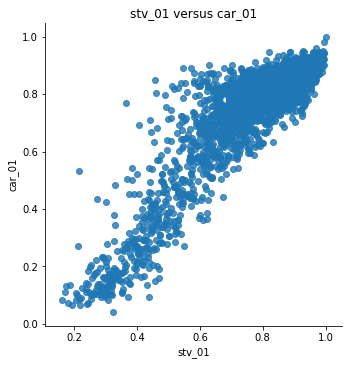

In [22]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.lmplot('stv_01', 'car_01', data = df_train, fit_reg=False);
plt.title('stv_01 versus car_01');
plt.show()

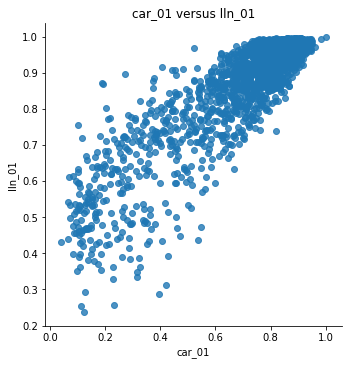

In [23]:
sns.lmplot('car_01', 'lln_01', data = df_train, fit_reg=False);
plt.title('car_01 versus lln_01');
plt.show()

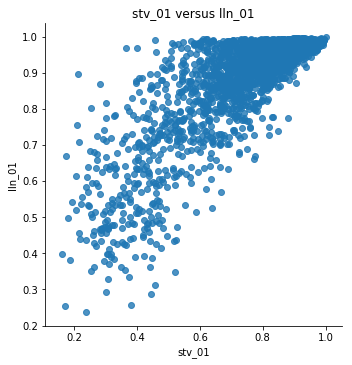

In [24]:
sns.lmplot('stv_01', 'lln_01', data = df_train, fit_reg=False);
plt.title('stv_01 versus lln_01');
plt.show()

In [25]:
np.random.randint(1, 2, size=1)

array([1])

In [0]:
# # in each column of dataframe
# uniqueValues = df_train.nunique()
 
# print('Count of unique values in each column :')
# print(uniqueValues)

In [28]:
new_data = dataset[feature_imp.tail(30)['Feature'].values]
new_data = new_data.sample(frac=1, axis=1)

# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(interaction_only=True)
# poly_fea = poly.fit_transform(new_data.iloc[:,:4])

# poly_fea = pd.DataFrame(poly_fea).drop(columns=[0,1,2,3,4])
# poly_fea.columns = ['a','b','c','d','e','f']
# for feature in  new_data.columns[:15]:
#     new_data[feature + '_log'] = (new_data[feature]+1).transform(np.log)

# new_data = pd.concat([poly_fea, new_data], axis=1, sort=True)

NameError: name 'new_data' is not defined

In [0]:
new_data

,lan_05,psa_01,pg_00,lan_10,pw_00,lan_03,lan_12,pg_03,lat,NL,...,psa_00,dw_04,dw_08,stv_00,lan_05_log,psa_01_log,pg_00_log,lan_10_log,pw_00_log,lan_03_log
0,0.000564,0.607898,0.357455,0.000372,0.742692,0.050939,0.002719,0.072996,-29.682270,0.292039,...,0.260191,0.000000,0.008080,0.283468,0.000564,0.474928,0.305612,0.000372,0.555431,0.049684
1,0.001759,0.549788,0.698428,0.000994,0.309294,0.011249,0.002439,0.015835,-29.119311,3.207775,...,0.290228,0.002301,0.151910,0.103641,0.001757,0.438118,0.529703,0.000994,0.269488,0.011187
2,0.002552,0.677005,0.672452,0.000779,0.323393,0.111270,0.002509,0.167494,-29.142276,0.000000,...,0.186435,0.007735,0.129902,0.165772,0.002548,0.517009,0.514291,0.000778,0.280199,0.105503
3,0.002308,0.593281,0.728014,0.000000,0.677437,0.086423,0.007442,0.000956,-29.372052,2.038778,...,0.281229,0.000813,0.218786,0.087768,0.002305,0.465795,0.546973,0.000000,0.517267,0.082891
4,0.002613,0.517578,0.753491,0.000643,0.771106,0.121869,0.004276,0.106953,-29.409381,0.000000,...,0.196687,0.006999,0.015382,0.345975,0.002610,0.417116,0.561608,0.000643,0.571604,0.114996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3830,0.003975,0.612635,0.257872,0.003400,0.992238,0.074446,0.087869,0.619228,-33.806524,33.913055,...,0.233077,0.069741,0.002530,0.658908,0.003967,0.477870,0.229421,0.003394,0.689259,0.071805
3831,0.003066,0.577557,0.955210,0.001250,0.433723,0.857461,0.014547,0.000531,-33.982120,60.009486,...,0.248120,0.000554,0.416686,0.070309,0.003061,0.455877,0.670498,0.001249,0.360275,0.619210
3832,0.000936,0.534385,0.248422,0.000680,0.733120,0.202490,0.006981,0.010415,-34.062704,35.834860,...,0.239656,0.000371,0.070348,0.187296,0.000936,0.428130,0.221881,0.000679,0.549923,0.184395
3833,0.000463,0.530802,0.058357,0.000255,0.934310,0.002739,0.006659,0.003929,-34.057772,50.153301,...,0.203364,0.000939,0.001687,0.320743,0.000463,0.425792,0.056717,0.000255,0.659751,0.002735


In [27]:
# dataset.drop(columns=['ward'], inplace=True)
df_train = new_data.iloc[:2822]
df_test = new_data.iloc[2822:]
df_test.reset_index(drop=True, inplace=True)

NameError: name 'new_data' is not defined

In [0]:
print(df_train.shape, df_test.shape)

(2822, 36) (1013, 36)


In [0]:
X = df_train
y = Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
train_data = lgb.Dataset(X_train,label=y_train)
val_data = lgb.Dataset(X_test,label=y_test)

In [0]:
#setting parameters for lightgbm
param = {'num_leaves':80, 'objective':'regression','max_depth':7,'learning_rate':0.09,'max_bin':150,
         'min_data_in_leaf': 20}
param['metric'] = ['rmse']

In [0]:
# LightGBM model
num_round=100
lgbm=lgb.train(param,train_data,num_round)
print(sqrt(mean_squared_error(y_train, lgbm.predict(X_train))))
print(sqrt(mean_squared_error(y_test, lgbm.predict(X_test))))

1.3145854034008686
3.133643180426309


In [0]:
model_xgb = XGBRegressor(n_estimators=1000,learning_rate=0.05,subsample = 0.5,min_child_weight=2,max_depth=5,
                         eta =0.6, gamma=0.5, reg_lambda = 2)

model_xgb.fit(X_train, y_train)
print(sqrt(mean_squared_error(y_train, model_xgb.predict(X_train))))
print(sqrt(mean_squared_error(y_test, model_xgb.predict(X_test))))

[23:41:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.31751516283295866
2.9598343460550556


In [0]:
feature_imp = pd.DataFrame(sorted(zip(rf.feature_importances_, X.columns)), columns=['Value','Feature'])

For the whole Train Data

In [0]:
num_round=100
train_data = lgb.Dataset(X,label=y)
lgbm=lgb.train(param,train_data,num_round)
print(sqrt(mean_squared_error(y, lgbm.predict(X))))

1.386151174925884


In [0]:
model_xgb = XGBRegressor(n_estimators=1200,learning_rate=0.05,subsample = 0.5,min_child_weight=2,max_depth=5,
                         eta =0.6, gamma=0.5, reg_lambda = 2)

model_xgb.fit(X, y)
sqrt(mean_squared_error(y, model_xgb.predict(X)))

[01:08:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.31943649394688645

In [0]:
pd.DataFrame(predictions, columns=['pred'])

,pred
0,17.237827
1,13.745220
2,19.533859
3,14.376145
4,21.027617
...,...
1008,6.353291
1009,21.127571
1010,17.938892
1011,15.461001


In [0]:
# avg_pre = (model_xgb.predict(df_test) + lgbm.predict(df_test))/2
predictions = model_xgb.predict(df_test)

# sqrt(mean_squared_error(y_test, avg_pre))

In [0]:
submission = pd.concat([ward, pd.DataFrame(rf.predict(df_test), columns=['pred'])], axis=1, sort=False)
submission

,ward,pred
0,21001001: Ward 1,17.794538
1,21001002: Ward 2,13.605522
2,21001003: Ward 3,21.258151
3,21001004: Ward 4,16.100878
4,21001005: Ward 5,21.435996
...,...,...
1008,19100107: Ward 107,7.452900
1009,19100108: Ward 108,22.336549
1010,19100109: Ward 109,17.993429
1011,19100110: Ward 110,15.189440


In [0]:
submission.to_csv('submission.csv', index=False)

In [0]:
rf = RandomForestRegressor(n_estimators=500, min_samples_split=6, max_features= 8,
                           min_samples_leaf=3,max_depth=10, bootstrap= False)
rf.fit(X_train, y_train)

print("RMSE:", sqrt(mean_squared_error(y_train, rf.predict(X_train))))
print("RMSE:", sqrt(mean_squared_error(y_test, rf.predict(X_test))))

/home/mohamud/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RMSE: 1.5035149084183252
RMSE: 3.253041441120627


In [0]:
rf = RandomForestRegressor(n_estimators=500, min_samples_split=6, max_features= 8,
                           min_samples_leaf=3,max_depth=10, bootstrap= False)
rf.fit(X, y)

print("RMSE:", sqrt(mean_squared_error(y, rf.predict(X))))

/home/mohamud/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RMSE: 1.5691905812885407


In [0]:
from sklearn.tree import DecisionTreeRegressor

DT = DecisionTreeRegressor(min_samples_split=10, min_samples_leaf=5,max_depth=10)
DT.fit(X_train, y_train)

print("RMSE:", sqrt(mean_squared_error(y_train, DT.predict(X_train))))
print("RMSE:", sqrt(mean_squared_error(y_test, DT.predict(X_test))))

RMSE: 2.209091926838388
RMSE: 4.465499833702039
